# Train nation-wide air quality model

## Find the optimal model

We know the optimal spatial unit but we don't know the optimal model. We will be testing a number of parameters:

- Distance of spatial lag
    - 1
    - 2
    - 3
    - 4
    - 5
- Type of spatial lag (weight)
    - binary (each neighbor is considered equal, irrelevant of distance)
    - inverse (inverse distance applied)
- Model architecture
    - HistGradientBoostingRegressor
- Model hyperparameters
    - bins {64, 128, 256, 512}
    - learning_rate {0.05, 0.1, 0.15, 0.2}
 
An extension once the optimal parameters from above are found:

- Inclusion of variables to capture regional variation
    - x, y coordinates

In [1]:
from time import time

import geopandas as gpd
import numpy as np
import joblib
import libpysal
import pandas as pd
import h3
import json
import esda
import seaborn as sns
import matplotlib.pyplot as plt

from libpysal import graph
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV

In [2]:
data_folder = "../../../demoland_data"

Load the data

In [3]:
data = gpd.read_parquet(f"{data_folder}/h3/grid_complete.parquet")

In [4]:
exvars = data.columns.drop(['geometry', 'air_quality_index', 'house_price_index', 'signature_type'])

1. split to 5 folds based on larger H3 level
3. get subset of weights per each fold
4. measure lags ([binary, weighted] * distance * fold)
5. perform a grid search + evaluation

_hope it won't blow up memory..._

## Define folds

In [5]:
parent_l6 = data.index.to_series().apply(lambda x: h3.h3_to_parent(x, 6))

In [6]:
unique_l6 = parent_l6.unique()

In [7]:
cv_ids = np.tile(np.arange(5), unique_l6.shape[0] // 5 + 1)[
    : unique_l6.shape[0]
]
rng = np.random.default_rng(0)
rng.shuffle(cv_ids)

In [8]:
fold_masks = {}
for i in range(5):
    fold_masks[i] = parent_l6.isin(unique_l6[cv_ids == i])

## Load and subset the graphs

Define functions that will make it to libpysal.

In [9]:
def subset_graph(g, ids):
    """Subset graph and ensure islands are preserved

    The order of ids reflects canonical order of ids
    according to which graph will be sorted.

    Returns (heads, tails, weights)
    """    
    masked_adj = g.adjacency[ids]
    filtered_adj = masked_adj[masked_adj.index.get_level_values("neighbor").isin(ids)]
    return graph.Graph.from_arrays(*_resolve_islands(
        filtered_adj.index.get_level_values("focal"),
        filtered_adj.index.get_level_values("neighbor"),
        ids,
        filtered_adj.values,
    ))

def _resolve_islands(heads, tails, ids, weights):
    """
    Induce self-loops for a collection of ids and links describing a
    contiguity graph. Induced self-loops will have zero weight.
    """
    
    islands = ids.difference(heads) 
    if islands.shape != (0,):
        heads = np.hstack((heads, islands))
        tails = np.hstack((tails, islands))
        weights = np.hstack((weights, np.zeros_like(islands, dtype=int)))

    # ensure proper order after adding isolates to the end
    adjacency = pd.Series(weights, index=pd.MultiIndex.from_arrays([heads, tails]))
    adjacency = adjacency.reindex(ids, level=0).reindex(ids, level=1)
    return (
        adjacency.index.get_level_values(0),
        adjacency.index.get_level_values(1),
        adjacency.values,
    )

In [10]:
parameters = {
    "learning_rate": (0.05, 0.1, 0.15), 
    "max_bins": (32, 64, 128, 255)
}

When starting for the first time

In [11]:
results = {}

When restarting from middle

In [58]:
def keystoint(x):
    return {int(k) if k.isdigit() else k: v for k, v in x.items()}

with open(f"{data_folder}/h3/results.json", "r") as f:
    results = json.load(f, object_hook=keystoint)

In [ ]:
%%time
for fold in range(5):
    if fold not in results:
        results[fold] = {}
    
    for weights in ["binary", "inverse"]:
        if weights not in results[fold]:
            results[fold][weights] = {}

        for distance in range(1, 6):
            s = time()
            if distance in results[fold][weights] and results[fold][weights][distance] != {}:
                print(f"Fold {fold}, {weights} weights, distance {distance} skipped (already done).")
                continue
                
            results[fold][weights][distance] = {}
            
            suffix = "" if distance == 5 else f"_k{distance}"
            matrix = graph.read_parquet(f"{data_folder}/h3/grid_adjacency_{weights}{suffix}.parquet")
            
            test_weights = subset_graph(matrix, data.index[fold_masks[fold]]).transform("r")
            train_weights = subset_graph(matrix, data.index[~fold_masks[fold]]).transform("r")
    
            test_lags = []
            train_lags = []
            for var in exvars:
                test_lags.append(test_weights.lag(data.loc[fold_masks[fold]][var]))
                train_lags.append(train_weights.lag(data.loc[~fold_masks[fold]][var]))
            test_lags = pd.DataFrame(
                np.vstack(test_lags).T, 
                index=data.index[fold_masks[fold]], 
                columns=exvars + "_lag_binary"
            )
            train_lags = pd.DataFrame(
                np.vstack(train_lags).T, 
                index=data.index[~fold_masks[fold]], 
                columns=exvars + "_lag_binary"
            )
    
            regressor = HistGradientBoostingRegressor(
                random_state=0, max_iter=500
            )
    
            search = GridSearchCV(regressor, parameters, verbose=0)
            search.fit(
                pd.concat(
                    [
                        data.loc[~fold_masks[fold], exvars],
                        train_lags
                    ], 
                    axis=1
                ), 
                data.air_quality_index[~fold_masks[fold]]
            )
            best = search.best_estimator_
            pred = best.predict(
                pd.concat(
                    [
                        data.loc[fold_masks[fold], exvars],
                        test_lags
                    ], 
                    axis=1
                )
            )
            results[fold][weights][distance]["mean_squared_error"] = metrics.mean_squared_error(
                data.air_quality_index[fold_masks[fold]],
                pred,
            )
            results[fold][weights][distance]["r2"] = metrics.r2_score(
                data.air_quality_index[fold_masks[fold]], 
                pred,
            )
            residuals = data.air_quality_index[fold_masks[fold]] - pred
            results[fold][weights][distance]["mean_error"] = residuals.abs().mean()
            results[fold][weights][distance]["median_error"] = residuals.abs().median()
            results[fold][weights][distance]["best_params"] = search.best_params_

            with open(f"{data_folder}/h3/results.json", "w") as f:
                json.dump(results, f)
            
            print(f"Fold {fold}, {weights} weights, distance {distance} done in {time() -s:.2f} s.")

Plot results

In [16]:
df = pd.DataFrame()
i = 0
for fold in results:
    for weights in results[fold]:
        for distance in results[fold][weights]:
            df.loc[
                i,
                ["fold", "weights", "distance"]
                + list(results[fold][weights][distance].keys()),
            ] = [fold, weights, distance] + list(
                results[fold][weights][distance].values())
            i += 1

/tmp/ipykernel_2989854/2065752068.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'binary' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[
/tmp/ipykernel_2989854/2065752068.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{'learning_rate': 0.05, 'max_bins': 32}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[


In [28]:
df.query("weights == 'binary' & distance == 5")

,fold,weights,distance,mean_squared_error,r2,mean_error,median_error,best_params
4,0.0,binary,5.0,1.241032,0.823486,0.819903,0.607144,"{'learning_rate': 0.1, 'max_bins': 128}"
14,1.0,binary,5.0,1.169427,0.846025,0.788155,0.577792,"{'learning_rate': 0.1, 'max_bins': 64}"
24,2.0,binary,5.0,1.210120,0.834941,0.803199,0.590220,"{'learning_rate': 0.1, 'max_bins': 128}"
34,3.0,binary,5.0,1.195895,0.835550,0.790984,0.581681,"{'learning_rate': 0.1, 'max_bins': 128}"
44,4.0,binary,5.0,1.123705,0.848892,0.779776,0.586036,"{'learning_rate': 0.1, 'max_bins': 128}"


Text(0.5, 1.0, 'median_error')

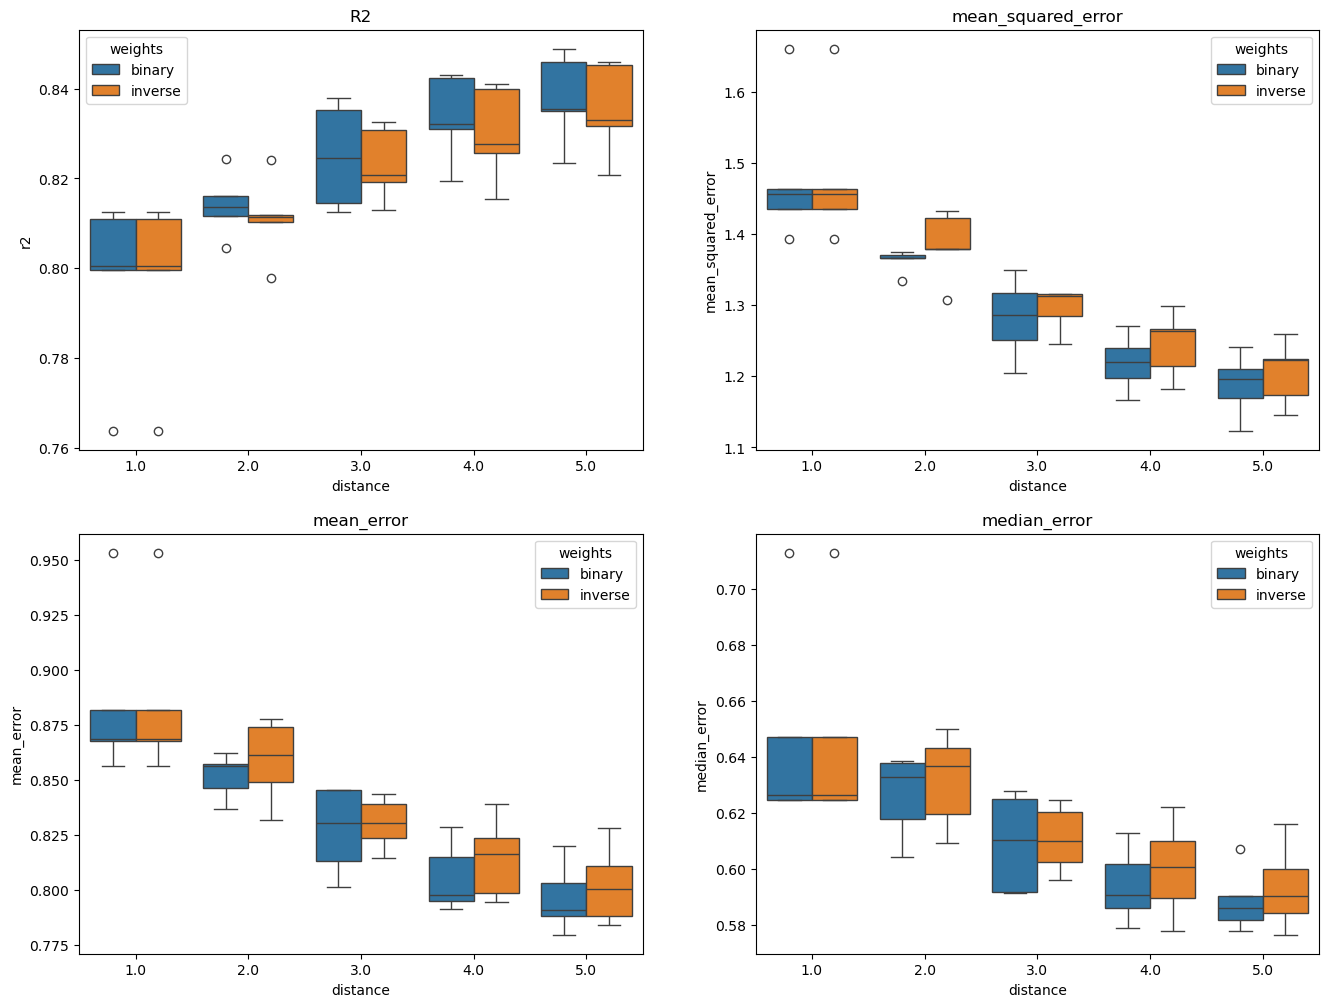

In [21]:
f, axs = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(data=df, x="distance", y="r2", hue="weights", ax=axs[0][0])
axs[0][0].set_title("R2")

sns.boxplot(data=df, x="distance", y="mean_squared_error", hue="weights", ax=axs[0][1])
axs[0][1].set_title("mean_squared_error")

sns.boxplot(data=df, x="distance", y="mean_error", hue="weights", ax=axs[1][0])
axs[1][0].set_title("mean_error")

sns.boxplot(data=df, x="distance", y="median_error", hue="weights", ax=axs[1][1])
axs[1][1].set_title("median_error")

Text(0.5, 1.0, 'median_error')

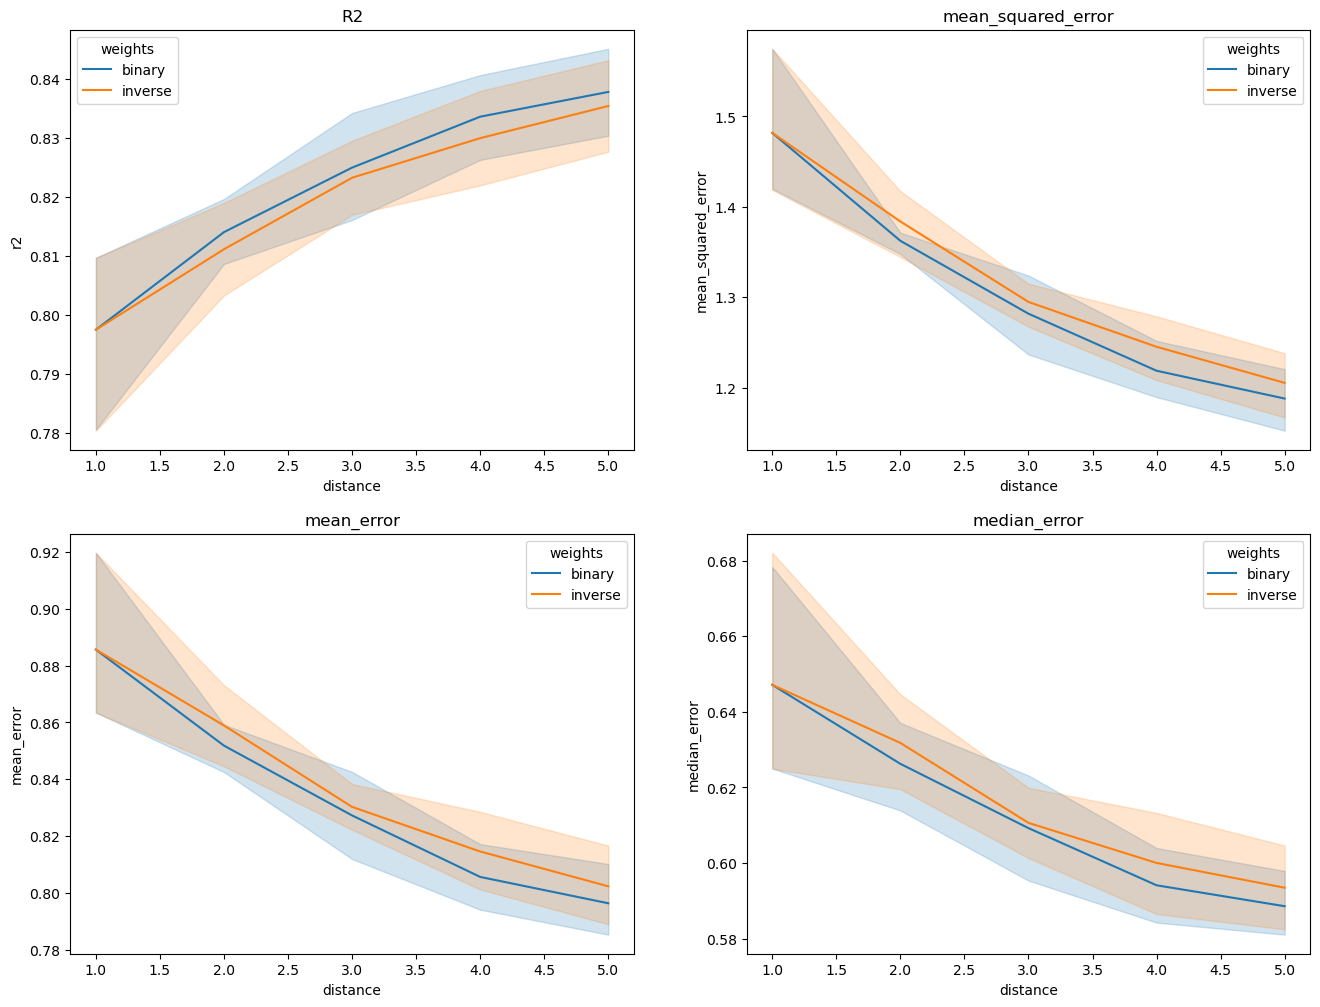

In [23]:
f, axs = plt.subplots(2, 2, figsize=(16, 12))

sns.lineplot(data=df, x="distance", y="r2", hue="weights", ax=axs[0][0])
axs[0][0].set_title("R2")

sns.lineplot(data=df, x="distance", y="mean_squared_error", hue="weights", ax=axs[0][1])
axs[0][1].set_title("mean_squared_error")

sns.lineplot(data=df, x="distance", y="mean_error", hue="weights", ax=axs[1][0])
axs[1][0].set_title("mean_error")

sns.lineplot(data=df, x="distance", y="median_error", hue="weights", ax=axs[1][1])
axs[1][1].set_title("median_error")

The best model seems to use **binary** weights at 5 orders of contiguity. Learning rate 0.1 with 128 max bins.

Let's fix these parameters and explore:

- Inclusion of variables to capture regional variation
    - x, y coordinates

Since the model is already very good (R2 above 0.8), and there is no reason to think that air pollution behaves differently in different regions (unlike house price) we don't need to test other ways of including space.

It seems that while there is a variation between the folds, it is not radical. We can stick to a single fold and compare with the same fold from CV above. Let's use fold 0 with the worst results as a conservative choice.

## Include latitude and longitude

In [36]:
fold = 0

matrix = graph.read_parquet(f"{data_folder}/h3/grid_adjacency_binary.parquet")
            
test_weights = subset_graph(matrix, data.index[fold_masks[fold]]).transform("r")
train_weights = subset_graph(matrix, data.index[~fold_masks[fold]]).transform("r")

test_lags = []
train_lags = []
for var in exvars:
    test_lags.append(test_weights.lag(data.loc[fold_masks[fold]][var]))
    train_lags.append(train_weights.lag(data.loc[~fold_masks[fold]][var]))
test_lags = pd.DataFrame(
    np.vstack(test_lags).T, 
    index=data.index[fold_masks[fold]], 
    columns=exvars + "_lag_binary"
)
train_lags = pd.DataFrame(
    np.vstack(train_lags).T, 
    index=data.index[~fold_masks[fold]], 
    columns=exvars + "_lag_binary"
)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [45]:
coords = pd.DataFrame(data.index.to_series().apply(h3.h3_to_geo).tolist(), columns=["lat", "lon"], index=data.index)

In [46]:
%%time
regressor_xy = HistGradientBoostingRegressor(
    random_state=0, max_iter=500, learning_rate=.1, max_bins=128
)
regressor_xy.fit(
    pd.concat(
        [
            data.loc[~fold_masks[fold], exvars],
            train_lags,
            coords.loc[~fold_masks[fold]],
        ], 
        axis=1
    ), 
    data.air_quality_index[~fold_masks[fold]]
)

CPU times: user 3min 22s, sys: 484 ms, total: 3min 23s
Wall time: 29.3 s


HistGradientBoostingRegressor(max_bins=128, max_iter=500, random_state=0)

In [47]:
pred = regressor_xy.predict(
    pd.concat(
        [
            data.loc[fold_masks[fold], exvars],
            test_lags,
            coords.loc[fold_masks[fold]],
        ], 
        axis=1
    )
)

In [48]:
results_expanded = pd.DataFrame(columns=["mean_squared_error", "r2", "mean_error", "median_error"])

In [49]:
results_expanded.loc["xy", "mean_squared_error"] = metrics.mean_squared_error(
    data.air_quality_index[fold_masks[fold]],
    pred,
)
results_expanded.loc["xy", "r2"] = metrics.r2_score(
    data.air_quality_index[fold_masks[fold]], 
    pred,
)
residuals = data.air_quality_index[fold_masks[fold]] - pred
results_expanded.loc["xy", "mean_error"] = residuals.abs().mean()
results_expanded.loc["xy", "median_error"] = residuals.abs().median()

results_expanded

,mean_squared_error,r2,mean_error,median_error
xy,0.36454,0.948151,0.416124,0.291653


In [51]:
df.query("weights == 'binary' & distance == 5 & fold == 0")

,fold,weights,distance,mean_squared_error,r2,mean_error,median_error,best_params
4,0.0,binary,5.0,1.241032,0.823486,0.819903,0.607144,"{'learning_rate': 0.1, 'max_bins': 128}"


Including latitude and longitude of cell centroids bumped the performance from 0.82 to 0.95 (R2). It is a question whether we are not encoding in something that a scenario would eventually change but such a change could not be propagated to the model as coordinates are fixed.

## Final model trained on all of the data

In [5]:
matrix = graph.read_parquet(f"{data_folder}/h3/grid_adjacency_binary.parquet").transform("r")

In [6]:
lags = []
for var in exvars:
    lags.append(matrix.lag(data[var]))

lags = pd.DataFrame(
    np.vstack(lags).T, 
    index=data.index, 
    columns=exvars + "_lag"
)

coords = pd.DataFrame(data.index.to_series().apply(h3.h3_to_geo).tolist(), columns=["lat", "lon"], index=data.index)

In [7]:
%%time
regressor_final = HistGradientBoostingRegressor(
    random_state=0, max_iter=1000, learning_rate=.1, max_bins=128
)
regressor_final.fit(
    pd.concat(
        [
            data[exvars],
            lags,
            coords,
        ], 
        axis=1
    ), 
    data.air_quality_index,
)

CPU times: user 7min 13s, sys: 726 ms, total: 7min 13s
Wall time: 59.8 s


HistGradientBoostingRegressor(max_bins=128, max_iter=1000, random_state=0)

In [8]:
with open(f"{data_folder}/h3/air_quality_model.joblib", "wb") as f:
    joblib.dump(regressor_final, f, compress=True)